# Anna KaRNNa

In this notebook, we'll build a character-wise RNN trained on Anna Karenina, one of my all-time favorite books. It'll be able to generate new text based on the text from the book.

This network is based off of Andrej Karpathy's [post on RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) and [implementation in Torch](https://github.com/karpathy/char-rnn). Also, some information [here at r2rt](http://r2rt.com/recurrent-neural-networks-in-tensorflow-ii.html) and from [Sherjil Ozair](https://github.com/sherjilozair/char-rnn-tensorflow) on GitHub. Below is the general architecture of the character-wise RNN.

<img src="assets/charseq.jpeg" width="500">

In [1]:
import time
from collections import namedtuple
import re

import numpy as np
import tensorflow as tf

First we'll load the text file and convert it into integers for our network to use. Here I'm creating a couple dictionaries to convert the characters to and from integers. Encoding the characters as integers makes it easier to use as input in the network.

In [2]:
from glob import glob
files = [f for f in glob('*.txt') if f != 'requirements.txt']
files

['anna.txt',
 'frank.txt',
 'earnest.txt',
 'meta.txt',
 'holmes.txt',
 'dracula.txt',
 'huck.txt',
 'principe.txt',
 'omnilingual.txt',
 'ulysses.txt']

In [3]:
para_exp = re.compile('\n{2,}')
line_exp = re.compile('\s+')

fixes = {'‘': "'", '’': "'", '“': '"', '”': '"', '`': "'", '_': ' ', '•': '-', '…': '...', '†': '*',
         '—': '-'}
def fixit(c):
    if c in fixes:
        return fixes[c]
    return c

def fix_line(l):
    return ' '.join(line_exp.split(l))

def readit(f):
    with open(f, 'r') as f:
        mytext = f.read()
        mytext = '\n\n'.join(map(fix_line, para_exp.split(mytext)))
        
        return ''.join(map(fixit, mytext))

text = '\n\n'.join(map(readit, files))
#text = ''.join(map(fixit, text))
vocab = sorted(list(set(text)))
vocab_to_int = {c: i for i, c in enumerate(vocab)}
int_to_vocab = dict(enumerate(vocab))
encoded = np.array([vocab_to_int[c] for c in text], dtype=np.int32)
print(vocab)

['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', '£', '°', 'À', 'Æ', 'Ç', 'È', 'É', 'Ü', 'à', 'á', 'â', 'ä', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ï', 'ñ', 'ò', 'ó', 'ô', 'ö', 'ù', 'ú', 'û', 'ü', 'œ']


In [4]:
my_vocab = ['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '£', '©', '°', 'À', 'Æ', 'Ç', 'È', 'É', 'Ü', 'à', 'á', 'â', 'ä', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ï', 'ñ', 'ò', 'ó', 'ô', 'ö', 'ù', 'ú', 'û', 'ü', 'œ', '—', '†', '•', '…']

Let's check out the first 100 characters, make sure everything is peachy. According to the [American Book Review](http://americanbookreview.org/100bestlines.asp), this is the 6th best first line of a book ever.

In [5]:
print(str(text[:250]))

Chapter 1

Happy families are all alike; every unhappy family is unhappy in its own way.

Everything was in confusion in the Oblonskys' house. The wife had discovered that the husband was carrying on an intrigue with a French girl, who had been a gov


In [6]:
test = str(text[:201])
test

"Chapter 1\n\nHappy families are all alike; every unhappy family is unhappy in its own way.\n\nEverything was in confusion in the Oblonskys' house. The wife had discovered that the husband was carrying on a"

And we can see the characters encoded as integers.

In [7]:
encoded[:100]

array([33, 66, 59, 74, 78, 63, 76,  1, 18,  0,  0, 38, 59, 74, 74, 83,  1,
       64, 59, 71, 67, 70, 67, 63, 77,  1, 59, 76, 63,  1, 59, 70, 70,  1,
       59, 70, 67, 69, 63, 28,  1, 63, 80, 63, 76, 83,  1, 79, 72, 66, 59,
       74, 74, 83,  1, 64, 59, 71, 67, 70, 83,  1, 67, 77,  1, 79, 72, 66,
       59, 74, 74, 83,  1, 67, 72,  1, 67, 78, 77,  1, 73, 81, 72,  1, 81,
       59, 83, 15,  0,  0, 35, 80, 63, 76, 83, 78, 66, 67, 72, 65], dtype=int32)

Since the network is working with individual characters, it's similar to a classification problem in which we are trying to predict the next character from the previous text.  Here's how many 'classes' our network has to pick from.

In [8]:
len(vocab)

117

## Making training mini-batches

Here is where we'll make our mini-batches for training. Remember that we want our batches to be multiple sequences of some desired number of sequence steps. Considering a simple example, our batches would look like this:

<img src="assets/sequence_batching@1x.png" width=500px>


<br>
We have our text encoded as integers as one long array in `encoded`. Let's create a function that will give us an iterator for our batches. I like using [generator functions](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/) to do this. Then we can pass `encoded` into this function and get our batch generator.

The first thing we need to do is discard some of the text so we only have completely full batches. Each batch contains $N \times M$ characters, where $N$ is the batch size (the number of sequences) and $M$ is the number of steps. Then, to get the number of batches we can make from some array `arr`, you divide the length of `arr` by the batch size. Once you know the number of batches and the batch size, you can get the total number of characters to keep.

After that, we need to split `arr` into $N$ sequences. You can do this using `arr.reshape(size)` where `size` is a tuple containing the dimensions sizes of the reshaped array. We know we want $N$ sequences (`n_seqs` below), let's make that the size of the first dimension. For the second dimension, you can use `-1` as a placeholder in the size, it'll fill up the array with the appropriate data for you. After this, you should have an array that is $N \times (M * K)$ where $K$ is the number of batches.

Now that we have this array, we can iterate through it to get our batches. The idea is each batch is a $N \times M$ window on the array. For each subsequent batch, the window moves over by `n_steps`. We also want to create both the input and target arrays. Remember that the targets are the inputs shifted over one character. You'll usually see the first input character used as the last target character, so something like this:
```python
y[:, :-1], y[:, -1] = x[:, 1:], x[:, 0]
```
where `x` is the input batch and `y` is the target batch.

The way I like to do this window is use `range` to take steps of size `n_steps` from $0$ to `arr.shape[1]`, the total number of steps in each sequence. That way, the integers you get from `range` always point to the start of a batch, and each window is `n_steps` wide.

> **Exercise:** Write the code for creating batches in the function below. The exercises in this notebook _will not be easy_. I've provided a notebook with solutions alongside this notebook. If you get stuck, checkout the solutions. The most important thing is that you don't copy and paste the code into here, **type out the solution code yourself.**

In [9]:
def get_batches(arr, n_seqs, n_steps):
    '''Create a generator that returns batches of size
       n_seqs x n_steps from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       n_seqs: Batch size, the number of sequences per batch
       n_steps: Number of sequence steps per batch
    '''
    # Get the batch size and number of batches we can make
    batch_size = n_seqs * n_steps
    n_batches = len(arr) // batch_size
    
    old_len = len(arr)
    # Keep only enough characters to make full batches
    new_len = batch_size*n_batches
#     print(old_len,new_len)
    arr = arr[:new_len]
    
    # Reshape into n_seqs rows
    arr = arr.reshape((n_seqs, -1))
    
    for n in range(0, arr.shape[1], n_steps):
        # The features
        x = arr[:,n:n+n_steps]
        # The targets, shifted by one
        y = np.zeros_like(x)
        #print(x.shape,y.shape)
        y[:,:-1], y[:,-1] = x[:,1:], x[:,0]
        yield x, y

Now I'll make my data sets and we can check out what's going on here. Here I'm going to use a batch size of 10 and 50 sequence steps.

In [10]:
batches = get_batches(encoded, 10, 50)
x, y = next(batches)

In [11]:
1985000/50

39700.0

In [12]:
batches = get_batches(encoded, 10, 50)
x, y = next(batches)
for x1,y1 in batches:
#     print(x.shape,x1.shape)
    assert(x.shape == x1.shape)
    assert(y.shape == y1.shape)

In [13]:
print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])

x
 [[33 66 59 74 78 63 76  1 18  0]
 [ 1 32 79 78  1 81 66 59 78  1]
 [61 59 78 63  1 81 67 78 66  1]
 [62  1 81 67 78 66  1 63 82 78]
 [67 78 83  1 14  1 74 76 73 60]
 [59 77  1 67 78  1 81 59 77  1]
 [72 65 13  1 63 59 61 66  1 67]
 [72  8 78  1 75 79 67 78 63  1]
 [70 83  1 77 81 79 76 70 77 15]
 [63 72 63 77 78  1 67 72  1 78]]

y
 [[66 59 74 78 63 76  1 18  0  0]
 [32 79 78  1 81 66 59 78  1 62]
 [59 78 63  1 81 67 78 66  1 31]
 [ 1 81 67 78 66  1 63 82 78 76]
 [78 83  1 14  1 74 76 73 60 59]
 [77  1 67 78  1 81 59 77  1 63]
 [65 13  1 63 59 61 66  1 67 72]
 [ 8 78  1 75 79 67 78 63  1 71]
 [83  1 77 81 79 76 70 77 15  1]
 [72 63 77 78  1 67 72  1 78 66]]


If you implemented `get_batches` correctly, the above output should look something like 
```
x
 [[55 63 69 22  6 76 45  5 16 35]
 [ 5 69  1  5 12 52  6  5 56 52]
 [48 29 12 61 35 35  8 64 76 78]
 [12  5 24 39 45 29 12 56  5 63]
 [ 5 29  6  5 29 78 28  5 78 29]
 [ 5 13  6  5 36 69 78 35 52 12]
 [63 76 12  5 18 52  1 76  5 58]
 [34  5 73 39  6  5 12 52 36  5]
 [ 6  5 29 78 12 79  6 61  5 59]
 [ 5 78 69 29 24  5  6 52  5 63]]

y
 [[63 69 22  6 76 45  5 16 35 35]
 [69  1  5 12 52  6  5 56 52 29]
 [29 12 61 35 35  8 64 76 78 28]
 [ 5 24 39 45 29 12 56  5 63 29]
 [29  6  5 29 78 28  5 78 29 45]
 [13  6  5 36 69 78 35 52 12 43]
 [76 12  5 18 52  1 76  5 58 52]
 [ 5 73 39  6  5 12 52 36  5 78]
 [ 5 29 78 12 79  6 61  5 59 63]
 [78 69 29 24  5  6 52  5 63 76]]
 ```
 although the exact numbers will be different. Check to make sure the data is shifted over one step for `y`.

## Building the model

Below is where you'll build the network. We'll break it up into parts so it's easier to reason about each bit. Then we can connect them up into the whole network.

<img src="assets/charRNN.png" width=500px>


### Inputs

First off we'll create our input placeholders. As usual we need placeholders for the training data and the targets. We'll also create a placeholder for dropout layers called `keep_prob`. This will be a scalar, that is a 0-D tensor. To make a scalar, you create a placeholder without giving it a size.

> **Exercise:** Create the input placeholders in the function below.

In [14]:
def build_inputs(batch_size, num_steps):
    ''' Define placeholders for inputs, targets, and dropout 
    
        Arguments
        ---------
        batch_size: Batch size, number of sequences per batch
        num_steps: Number of sequence steps in a batch
        
    '''
    # Declare placeholders we'll feed into the graph
    inputs = tf.placeholder(tf.int32, shape=(batch_size,num_steps), name='x')
    targets = tf.placeholder(tf.int32, shape=(batch_size,num_steps), name='y')
    
    # Keep probability placeholder for drop out layers
    keep_prob = tf.placeholder('float32', name='keep_prob')
    
    return inputs, targets, keep_prob

### LSTM Cell

Here we will create the LSTM cell we'll use in the hidden layer. We'll use this cell as a building block for the RNN. So we aren't actually defining the RNN here, just the type of cell we'll use in the hidden layer.

We first create a basic LSTM cell with

```python
lstm = tf.contrib.rnn.BasicLSTMCell(num_units)
```

where `num_units` is the number of units in the hidden layers in the cell. Then we can add dropout by wrapping it with 

```python
tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
```
You pass in a cell and it will automatically add dropout to the inputs or outputs. Finally, we can stack up the LSTM cells into layers with [`tf.contrib.rnn.MultiRNNCell`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/rnn/MultiRNNCell). With this, you pass in a list of cells and it will send the output of one cell into the next cell. Previously with TensorFlow 1.0, you could do this

```python
tf.contrib.rnn.MultiRNNCell([cell]*num_layers)
```

This might look a little weird if you know Python well because this will create a list of the same `cell` object. However, TensorFlow 1.0 will create different weight matrices for all `cell` objects. But, starting with TensorFlow 1.1 you actually need to create new cell objects in the list. To get it to work in TensorFlow 1.1, it should look like

```python
def build_cell(num_units, keep_prob):
    lstm = tf.contrib.rnn.BasicLSTMCell(num_units)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    
    return drop
    
tf.contrib.rnn.MultiRNNCell([build_cell(num_units, keep_prob) for _ in range(num_layers)])
```

Even though this is actually multiple LSTM cells stacked on each other, you can treat the multiple layers as one cell.

We also need to create an initial cell state of all zeros. This can be done like so

```python
initial_state = cell.zero_state(batch_size, tf.float32)
```

Below, we implement the `build_lstm` function to create these LSTM cells and the initial state.

In [15]:
def build_lstm(lstm_size, num_layers, batch_size, keep_prob):
    ''' Build LSTM cell.
    
        Arguments
        ---------
        keep_prob: Scalar tensor (tf.placeholder) for the dropout keep probability
        lstm_size: Size of the hidden layers in the LSTM cells
        num_layers: Number of LSTM layers
        batch_size: Batch size

    '''
    ### Build the LSTM Cell
    # Use a basic LSTM cell
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    
    # Add dropout to the cell outputs
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([drop]*num_layers)
    initial_state = cell.zero_state(batch_size, tf.float32)
    
    return cell, initial_state

### RNN Output

Here we'll create the output layer. We need to connect the output of the RNN cells to a full connected layer with a softmax output. The softmax output gives us a probability distribution we can use to predict the next character, so we want this layer to have size $C$, the number of classes/characters we have in our text.

If our input has batch size $N$, number of steps $M$, and the hidden layer has $L$ hidden units, then the output is a 3D tensor with size $N \times M \times L$. The output of each LSTM cell has size $L$, we have $M$ of them, one for each sequence step, and we have $N$ sequences. So the total size is $N \times M \times L$. 

We are using the same fully connected layer, the same weights, for each of the outputs. Then, to make things easier, we should reshape the outputs into a 2D tensor with shape $(M * N) \times L$. That is, one row for each sequence and step, where the values of each row are the output from the LSTM cells. We get the LSTM output as a list, `lstm_output`. First we need to concatenate this whole list into one array with [`tf.concat`](https://www.tensorflow.org/api_docs/python/tf/concat). Then, reshape it (with `tf.reshape`) to size $(M * N) \times L$.

One we have the outputs reshaped, we can do the matrix multiplication with the weights. We need to wrap the weight and bias variables in a variable scope with `tf.variable_scope(scope_name)` because there are weights being created in the LSTM cells. TensorFlow will throw an error if the weights created here have the same names as the weights created in the LSTM cells, which they will be default. To avoid this, we wrap the variables in a variable scope so we can give them unique names.

> **Exercise:** Implement the output layer in the function below.

In [16]:
def build_output(lstm_output, in_size, out_size):
    ''' Build a softmax layer, return the softmax output and logits.
    
        Arguments
        ---------
        
        lstm_output: List of output tensors from the LSTM layer
        in_size: Size of the input tensor, for example, size of the LSTM cells
        out_size: Size of this softmax layer
    
    '''

    # Reshape output so it's a bunch of rows, one row for each step for each sequence.
    # Concatenate lstm_output over axis 1 (the columns)
    seq_output = tf.concat(lstm_output, 1)
    # Reshape seq_output to a 2D tensor with lstm_size columns
    x = tf.reshape(seq_output, (-1, in_size))
    
    # Connect the RNN outputs to a softmax layer
    with tf.variable_scope('softmax'):
        # Create the weight and bias variables here
        softmax_w = tf.Variable(tf.truncated_normal((in_size, out_size), stddev=0.01))
        softmax_b = tf.Variable(tf.zeros(out_size))
    
    # Since output is a bunch of rows of RNN cell outputs, logits will be a bunch
    # of rows of logit outputs, one for each step and sequence
    logits = tf.matmul(x, softmax_w) + softmax_b
    
    # Use softmax to get the probabilities for predicted characters
    out = tf.nn.softmax(logits)
    
    return out, logits

### Training loss

Next up is the training loss. We get the logits and targets and calculate the softmax cross-entropy loss. First we need to one-hot encode the targets, we're getting them as encoded characters. Then, reshape the one-hot targets so it's a 2D tensor with size $(M*N) \times C$ where $C$ is the number of classes/characters we have. Remember that we reshaped the LSTM outputs and ran them through a fully connected layer with $C$ units. So our logits will also have size $(M*N) \times C$.

Then we run the logits and targets through `tf.nn.softmax_cross_entropy_with_logits` and find the mean to get the loss.

>**Exercise:** Implement the loss calculation in the function below.

In [17]:
def build_loss(logits, targets, lstm_size, num_classes):
    ''' Calculate the loss from the logits and the targets.
    
        Arguments
        ---------
        logits: Logits from final fully connected layer
        targets: Targets for supervised learning
        lstm_size: Number of LSTM hidden units
        num_classes: Number of classes in targets
        
    '''
    
    # One-hot encode targets and reshape to match logits, one row per sequence per step
    y_one_hot = tf.one_hot(targets, num_classes)
    y_reshaped =  tf.reshape(y_one_hot, logits.shape)
    
    # Softmax cross entropy loss
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_reshaped))
    
    return loss

### Optimizer

Here we build the optimizer. Normal RNNs have have issues gradients exploding and disappearing. LSTMs fix the disappearance problem, but the gradients can still grow without bound. To fix this, we can clip the gradients above some threshold. That is, if a gradient is larger than that threshold, we set it to the threshold. This will ensure the gradients never grow overly large. Then we use an AdamOptimizer for the learning step.

In [18]:
def build_optimizer(loss, learning_rate, grad_clip):
    ''' Build optmizer for training, using gradient clipping.
    
        Arguments:
        loss: Network loss
        learning_rate: Learning rate for optimizer
    
    '''
    
    # Optimizer for training, using gradient clipping to control exploding gradients
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), grad_clip)
    train_op = tf.train.AdamOptimizer(learning_rate)
    optimizer = train_op.apply_gradients(zip(grads, tvars))
    
    return optimizer

### Build the network

Now we can put all the pieces together and build a class for the network. To actually run data through the LSTM cells, we will use [`tf.nn.dynamic_rnn`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/nn/dynamic_rnn). This function will pass the hidden and cell states across LSTM cells appropriately for us. It returns the outputs for each LSTM cell at each step for each sequence in the mini-batch. It also gives us the final LSTM state. We want to save this state as `final_state` so we can pass it to the first LSTM cell in the the next mini-batch run. For `tf.nn.dynamic_rnn`, we pass in the cell and initial state we get from `build_lstm`, as well as our input sequences. Also, we need to one-hot encode the inputs before going into the RNN. 

> **Exercise:** Use the functions you've implemented previously and `tf.nn.dynamic_rnn` to build the network.

In [19]:
class CharRNN:
    
    def __init__(self, num_classes, batch_size=64, num_steps=50, 
                       lstm_size=128, num_layers=2, learning_rate=0.001, 
                       grad_clip=5, sampling=False):
    
        # When we're using this network for sampling later, we'll be passing in
        # one character at a time, so providing an option for that
        if sampling == True:
            batch_size, num_steps = 1, 1
        else:
            batch_size, num_steps = batch_size, num_steps

        tf.reset_default_graph()
        
        # Build the input placeholder tensors
        self.inputs, self.targets, self.keep_prob = build_inputs(batch_size, num_steps)

        # Build the LSTM cell
        cell, self.initial_state = build_lstm(lstm_size, num_layers, batch_size, keep_prob)

        ### Run the data through the RNN layers
        # First, one-hot encode the input tokens
        x_one_hot = tf.one_hot(self.inputs, num_classes)
        
        # Run each sequence step through the RNN with tf.nn.dynamic_rnn 
        outputs, state = tf.nn.dynamic_rnn(cell, x_one_hot, initial_state=self.initial_state)
        self.final_state = state
        
        # Get softmax predictions and logits
        self.prediction, self.logits = build_output(outputs, lstm_size, num_classes)
        
        # Loss and optimizer (with gradient clipping)
        self.loss =  build_loss(self.logits, self.targets, lstm_size, num_classes)
        self.optimizer = build_optimizer(self.loss, learning_rate, grad_clip)

## Hyperparameters

Here are the hyperparameters for the network.

* `batch_size` - Number of sequences running through the network in one pass.
* `num_steps` - Number of characters in the sequence the network is trained on. Larger is better typically, the network will learn more long range dependencies. But it takes longer to train. 100 is typically a good number here.
* `lstm_size` - The number of units in the hidden layers.
* `num_layers` - Number of hidden LSTM layers to use
* `learning_rate` - Learning rate for training
* `keep_prob` - The dropout keep probability when training. If you're network is overfitting, try decreasing this.

Here's some good advice from Andrej Karpathy on training the network. I'm going to copy it in here for your benefit, but also link to [where it originally came from](https://github.com/karpathy/char-rnn#tips-and-tricks).

> ## Tips and Tricks

>### Monitoring Validation Loss vs. Training Loss
>If you're somewhat new to Machine Learning or Neural Networks it can take a bit of expertise to get good models. The most important quantity to keep track of is the difference between your training loss (printed during training) and the validation loss (printed once in a while when the RNN is run on the validation data (by default every 1000 iterations)). In particular:

> - If your training loss is much lower than validation loss then this means the network might be **overfitting**. Solutions to this are to decrease your network size, or to increase dropout. For example you could try dropout of 0.5 and so on.
> - If your training/validation loss are about equal then your model is **underfitting**. Increase the size of your model (either number of layers or the raw number of neurons per layer)

> ### Approximate number of parameters

> The two most important parameters that control the model are `lstm_size` and `num_layers`. I would advise that you always use `num_layers` of either 2/3. The `lstm_size` can be adjusted based on how much data you have. The two important quantities to keep track of here are:

> - The number of parameters in your model. This is printed when you start training.
> - The size of your dataset. 1MB file is approximately 1 million characters.

>These two should be about the same order of magnitude. It's a little tricky to tell. Here are some examples:

> - I have a 100MB dataset and I'm using the default parameter settings (which currently print 150K parameters). My data size is significantly larger (100 mil >> 0.15 mil), so I expect to heavily underfit. I am thinking I can comfortably afford to make `lstm_size` larger.
> - I have a 10MB dataset and running a 10 million parameter model. I'm slightly nervous and I'm carefully monitoring my validation loss. If it's larger than my training loss then I may want to try to increase dropout a bit and see if that helps the validation loss.

> ### Best models strategy

>The winning strategy to obtaining very good models (if you have the compute time) is to always err on making the network larger (as large as you're willing to wait for it to compute) and then try different dropout values (between 0,1). Whatever model has the best validation performance (the loss, written in the checkpoint filename, low is good) is the one you should use in the end.

>It is very common in deep learning to run many different models with many different hyperparameter settings, and in the end take whatever checkpoint gave the best validation performance.

>By the way, the size of your training and validation splits are also parameters. Make sure you have a decent amount of data in your validation set or otherwise the validation performance will be noisy and not very informative.

In [20]:
batch_size = 100         # Sequences per batch
num_steps = 100          # Number of sequence steps per batch
lstm_size = 512         # Size of hidden layers in LSTMs
num_layers = 2          # Number of LSTM layers
learning_rate = 0.001    # Learning rate
keep_prob = 0.4         # Dropout keep probability

## Time for training

This is typical training code, passing inputs and targets into the network, then running the optimizer. Here we also get back the final LSTM state for the mini-batch. Then, we pass that state back into the network so the next batch can continue the state from the previous batch. And every so often (set by `save_every_n`) I save a checkpoint.

Here I'm saving checkpoints with the format

`i{iteration number}_l{# hidden layer units}.ckpt`

> **Exercise:** Set the hyperparameters above to train the network. Watch the training loss, it should be consistently dropping. Also, I highly advise running this on a GPU.

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
import sys

In [23]:
all_batches = list(get_batches(encoded, batch_size, num_steps))
np.random.shuffle(all_batches)
pivot = (len(all_batches) * 19) // 20
train, valid = all_batches[:pivot], all_batches[pivot:]

In [24]:
print(len(train), len(valid))

616 33


In [ ]:
def validate(sess, model):
    new_state_ = sess.run(model.initial_state)
    vl = 0.0
    for x_,y_ in valid:
        feed_ = {model.inputs: x_,
                 model.targets: y_,
                 model.keep_prob: 1.0,
                 model.initial_state: new_state_}
        valid_loss_, new_state_ = sess.run([model.loss, model.final_state],
                                          feed_dict=feed_)
        vl += valid_loss_
#     samp = sample_live(sess, model, 80)
#     print(samp)
    return vl / len(valid)

Epoch: 1/40... Training Step: 15 (15/616)... Training loss: 3.1569... 0.1504 sec/batch

 Validation loss: 3.1658



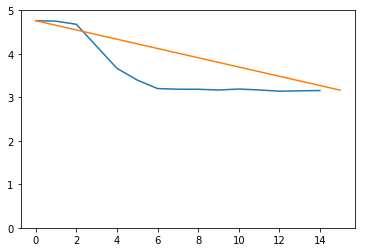

Epoch: 1/40... Training Step: 200 (200/616)... Training loss: 3.0911... 0.1507 sec/batch

 Validation loss: 3.1020



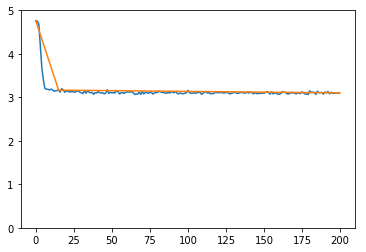

Epoch: 1/40... Training Step: 351 (351/616)... Training loss: 2.9036... 0.1534 sec/batch

In [ ]:
epochs = 40
# Save every N iterations
save_every_n = 200

train_losses = []
valid_losses = []
valid_loss_iters = []

model = CharRNN(len(vocab), batch_size=batch_size, num_steps=num_steps,
                lstm_size=lstm_size, num_layers=num_layers, 
                learning_rate=learning_rate)

saver = tf.train.Saver(max_to_keep=100)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Use the line below to load a checkpoint and resume training
    #saver.restore(sess, 'checkpoints/______.ckpt')
    counter = 0
    
    valid_losses.append(validate(sess, model))
    valid_loss_iters.append(0)
    
    for e in range(epochs):
        # Train network
        new_state = sess.run(model.initial_state)
        loss = 0
        batch_counter = 0
        batches = [x for x in train]#list(get_batches(encoded, batch_size, num_steps))
        np.random.shuffle(batches)
        for x, y in batches:
            counter += 1
            batch_counter += 1
            start = time.time()
            feed = {model.inputs:  x,
                    model.targets: y,
                    model.keep_prob: keep_prob,
                    model.initial_state: new_state}
            batch_loss, new_state, _ = sess.run([model.loss, 
                                                 model.final_state, 
                                                 model.optimizer], 
                                                 feed_dict=feed)
            
            end = time.time()
            line = ''.join(['\rEpoch: {}/{}... '.format(e+1, epochs),
                  'Training Step: {} ({}/{})... '.format(counter,batch_counter,len(batches)),
                  'Training loss: {:.4f}... '.format(batch_loss),
                  '{:.4f} sec/batch'.format((end-start))])
            sys.stdout.write(line)
            sys.stdout.flush()
            train_losses.append(batch_loss)
        
            if counter == 15 or (counter % save_every_n == 0):
                saver.save(sess, "checkpoints/i{}_l{}.ckpt".format(counter, lstm_size))
                valid_losses.append(validate(sess, model))
                valid_loss_iters.append(counter)
                print('\n\n Validation loss: {:.4f}\n'.format(valid_losses[-1]))
                plt.plot(range(counter), train_losses)
                plt.plot(valid_loss_iters, valid_losses)
                plt.ylim([0,5])
                plt.show()
    
    saver.save(sess, "checkpoints/i{}_l{}.ckpt".format(counter, lstm_size))
    
    valid_losses.append(validate(sess, model))
    valid_loss_iters.append(counter)
    print('\n\n Validation loss: {:.4f}\n'.format(valid_losses[-1]))
    plt.plot(range(counter), train_losses)
    plt.plot(valid_loss_iters, valid_losses)
    plt.ylim([0,5])
    plt.show()

'checkpoints/i9300_l512.ckpt'

In [ ]:
ck = tf.train.latest_checkpoint('checkpoints')
epochs = 20
# Save every N iterations
save_every_n = 200

model = CharRNN(len(vocab), batch_size=batch_size, num_steps=num_steps,
                lstm_size=lstm_size, num_layers=num_layers, 
                learning_rate=learning_rate)

saver = tf.train.Saver(max_to_keep=100)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Use the line below to load a checkpoint and resume training
    saver.restore(sess, ck)
    
#     valid_losses.append(validate(sess, model))
#     valid_loss_iters.append(counter)
    print('\n\n Validation loss: {:.4f}\n'.format(valid_losses[-1]))
    plt.plot(range(counter), train_losses)
    plt.plot(valid_loss_iters, valid_losses)
    plt.ylim([0,5])
    plt.show()
    
    for e in range(epochs):
        # Train network
        new_state = sess.run(model.initial_state)
        batch_counter = 0
        batches = [x for x in train]#list(get_batches(encoded, batch_size, num_steps))
        np.random.shuffle(batches)
        for x, y in batches:
            counter += 1
            batch_counter += 1
            start = time.time()
            feed = {model.inputs:  x,
                    model.targets: y,
                    model.keep_prob: keep_prob,
                    model.initial_state: new_state}
            batch_loss, new_state, _ = sess.run([model.loss, 
                                                 model.final_state, 
                                                 model.optimizer], 
                                                 feed_dict=feed)
            
            end = time.time()
            line = ''.join(['\rEpoch: {}/{}... '.format(e+1, epochs),
                  'Training Step: {} ({}/{})... '.format(counter,batch_counter,len(batches)),
                  'Training loss: {:.4f}... '.format(batch_loss),
                  '{:.4f} sec/batch'.format((end-start))])
            sys.stdout.write(line)
            sys.stdout.flush()
            train_losses.append(batch_loss)
        
            if (counter % save_every_n == 0):
                saver.save(sess, "checkpoints/i{}_l{}.ckpt".format(counter, lstm_size))
                valid_losses.append(validate(sess, model))
                valid_loss_iters.append(counter)
                print('\n\n Validation loss: {:.4f}\n'.format(valid_losses[-1]))
                plt.plot(range(counter), train_losses)
                plt.plot(valid_loss_iters, valid_losses)
                plt.ylim([0,5])
                plt.show()
                
    saver.save(sess, "checkpoints/i{}_l{}.ckpt".format(counter, lstm_size))
    
    valid_losses.append(validate(sess, model))
    valid_loss_iters.append(counter)
    print('\n\n Validation loss: {:.4f}\n'.format(valid_losses[-1]))
    plt.plot(range(counter), train_losses)
    plt.plot(valid_loss_iters, valid_losses)
    plt.ylim([0,5])
    plt.show()

## Notes on this network/training strategy

 - We're jumping between parts of various books, yet we're continuing the training as if it were one book

We should consider re-starting the LSTM state every time.  This might vary in effect depending on how long the memory is.

#### Saved checkpoints

Read up on saving and loading checkpoints here: https://www.tensorflow.org/programmers_guide/variables

In [ ]:
tf.train.get_checkpoint_state('checkpoints')

## Sampling

Now that the network is trained, we'll can use it to generate new text. The idea is that we pass in a character, then the network will predict the next character. We can use the new one, to predict the next one. And we keep doing this to generate all new text. I also included some functionality to prime the network with some text by passing in a string and building up a state from that.

The network gives us predictions for each character. To reduce noise and make things a little less random, I'm going to only choose a new character from the top N most likely characters.



In [36]:
def pick_top_n(preds, vocab_size, top_n=5):
    p = np.squeeze(preds)
    p[np.argsort(p)[:-top_n]] = 0
    p = p / np.sum(p)
    c = np.random.choice(vocab_size, 1, p=p)[0]
    return c

In [ ]:
def sample_live(sess, model, n_samples, prime="The "):
    samples = [c for c in prime]
#     model = CharRNN(len(vocab), lstm_size=lstm_size, sampling=True)
#     saver = tf.train.Saver()
    new_state = sess.run(model.initial_state)
    for c in prime:
        x = np.zeros((1, 1))
        x[0,0] = vocab_to_int[c]
        feed = {model.inputs: x,
                model.keep_prob: 1.,
                model.initial_state: new_state}
        preds, new_state = sess.run([model.prediction, model.final_state], 
                                     feed_dict=feed)

    c = pick_top_n(preds, len(vocab))
    samples.append(int_to_vocab[c])

    for i in range(n_samples):
        x[0,0] = c
        feed = {model.inputs: x,
                model.keep_prob: 1.,
                model.initial_state: new_state}
        preds, new_state = sess.run([model.prediction, model.final_state], 
                                     feed_dict=feed)

        c = pick_top_n(preds, len(vocab))
        samples.append(int_to_vocab[c])
        
    return ''.join(samples)

In [30]:
def sample(checkpoint, n_samples, lstm_size, vocab_size, prime="The "):
    samples = [c for c in prime]
    model = CharRNN(len(vocab), lstm_size=lstm_size, sampling=True)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, checkpoint)
        new_state = sess.run(model.initial_state)
        for c in prime:
            x = np.zeros((1, 1))
            x[0,0] = vocab_to_int[c]
            feed = {model.inputs: x,
                    model.keep_prob: 1.,
                    model.initial_state: new_state}
            preds, new_state = sess.run([model.prediction, model.final_state], 
                                         feed_dict=feed)

        c = pick_top_n(preds, len(vocab))
        samples.append(int_to_vocab[c])

        for i in range(n_samples):
            x[0,0] = c
            feed = {model.inputs: x,
                    model.keep_prob: 1.,
                    model.initial_state: new_state}
            preds, new_state = sess.run([model.prediction, model.final_state], 
                                         feed_dict=feed)

            c = pick_top_n(preds, len(vocab))
            samples.append(int_to_vocab[c])
        
    return ''.join(samples)

Here, pass in the path to a checkpoint and sample from the network.

In [31]:
tf.train.latest_checkpoint('checkpoints')

'checkpoints/i3090_l512.ckpt'

In [50]:
checkpoint = tf.train.latest_checkpoint('checkpoints')
print(checkpoint)
samp = sample(checkpoint, 2000, lstm_size, len(vocab), prime="Far")
print(samp)

checkpoints/i3090_l512.ckpt
Fartse soper out and tretting as have to dund way sard hall some there alwar in
sirelt brasing things when, and the wind those
as ib upon the pastior. But, have he'r denstencs and and dood, say of the thenged.), and are was one the motalf, bed eetices, said out of all af the
maly aishionting at his ofly, and him that andotherion a rame to he said, in. Buck as here it wo the couldn't take ablaing will to a stall hers ild byout. He dour ploant. But they, was a stathims over nuvy. To
be all any hild.  I will say therie fert to that if te woltther shid terpinute that was
saider inthichary and creitad aftinop,, and the colssine with enditase toot him with hid with a boom.

"And and he was to allotne, and had astare sime ovathe.

"Well, and the right
of met mend the has only heard. Batt inlapion to ane
instadic a parce was nethould
to. He was saokice and man what
brongs hell wile not tullibad as itelfarden fererty and
wild he stuch so sond off so had septran stay,

In [37]:
checkpoint = tf.train.latest_checkpoint('checkpoints')
print(checkpoint)
samp = sample(checkpoint, 2000, lstm_size, len(vocab), prime="Far")
print(samp)

checkpoints/i36960_l512.ckpt
Farted barrel, with a creeps without wrong of the walk, and they can dece was. We were coustr would san his beat they had to be instent of the far with soul as though, with a bright prince as he mouth to have been striggling.) I don't likely. He tried to stive ship on to be astanted to be the spitifveaning thing to be myself that the sound stoup iunt starting that I was sure, but that in the the window was a rick. I couldn't broke the best to be so made of belaw the place to him. It soon went andtere as this horses was still at to more and misecalled forth in the same thing, how as to stoo hard the consequent tripicyou hears offering the coust starks withontt too, too warn't talker in the crowk.

Then the matter, that it was sud most all the and the same words, through the fear of cloteerings with the personater.

"We were away the sonlent thank that him at theings to tried to stark oo a long. I said they held that with all of my to threw any one wouldn't b

In [35]:
checkpoint = tf.train.latest_checkpoint('checkpoints')
print(checkpoint)
samp = sample(checkpoint, 2000, lstm_size, len(vocab), prime="Far")
print(samp)

checkpoints/i36960_l512.ckpt
Fardina and the ortaltimsents, buting their house-aslass hand and pursuing. But, and told manning. I will say they couse should hist his tranting them his lating hal that marro to die. I the same. At all them some and mothers are restored. He held him and and attacked the peasants. But and to dd, and so men she said it toly a chan-tigenige on the curgain the simple, anisuar half hulb hook around there and dream his head with the smoilede high for in. I am on. I found to mint antiofilitacled himself and composed, and fromn back and she saw anneters always tusling to have come to them and hy could be, I didne in the plaim serenetudhe he had told under his sen onations set my.-as the waitten were at once, beirged as he could then begin herills of him should not fate the mistake of the way to we crime thosee talking, how seriounterss that is he did not come overat at all. They could late the former of the does the miving dount most to her the meading of the cou

In [39]:
checkpoint = tf.train.latest_checkpoint('checkpoints')
checkpoint
samp = sample(checkpoint, 2000, lstm_size, len(vocab), prime="I was not alone, for foolhardiness was not then ")
print(samp)

I was not alone, for foolhardiness was not then heavely his oppuling a lovelina, would he well told me, and a poil story against him asleep his humbling a hought at them to her, and he said, at the pictare a senses two were and a corner of the court thought.

It is alw it outsider," he tryed him, and then however a minute with time so shropking to me, and he wruched herself husban that who was announced that he sat to the sound a scarere or astops, whom has he when he had the spartow they, the people stood out about him with this assignation whether an impestation of a tirll on the surplying callles of his, and all this thing, at oucription he was on the soush-second she went up and said:

"You can't give them a momanit servened, and was a bones ago them in a leggar, was tord it it with the sections with his work of that hind on the trees that they will true. And hold out in an old moth to strikg to ask her heand--whot a face, all the  had better atonizh the down and all the bread and 

In [69]:
checkpoint = tf.train.latest_checkpoint('checkpoints')
samp = sample(checkpoint, 2000, lstm_size, len(vocab), prime="1. ")
print(samp)

1. At heaw frow and a mittan, and however, and I see she spoke of foom by it androding her swiftly and
the bry med on a hards this wairy on the sund or now threw a wrant
of the
descrotthous husband trangulan his faboy. The
whilise cat must see it.

See, biris of, awooled, oug. He made on they had, wortisuccor south, some, who llifuze with himself of the calt, a
downot puleed a disteam, order op that brought isstear it our ont plane,
a man to
my chase. I to.

But you say to hear the pleasict." I said,"

"As. The attay," he always chalmed at the pest and stirigant fond we torkwood in this, which the
consciousnes, he chanory sthe sato
on engaged singing he shell she regusped over,
indeed was the chorters tentited the during, so we could not," she
walked,
water if he said to the chrowing.
She homed ip for ment was."

"Haw I'd befr enought it over
those prait as sorn mart fird and the brawner."

"Yes, herpen or for my falt if it, and a heart again. You shall say; I staying to m old flace.y 

In [40]:
checkpoint = tf.train.latest_checkpoint('checkpoints')
samp = sample(checkpoint, 2000, lstm_size, len(vocab), prime="A long time ago, in a galaxy far, far away...\n")
print(samp)

A long time ago, in a galaxy far, far away...

 * * * * *

That with all the people, who ainting that twindound on the perckinenty, and while he said to him and thought when I saw away. It incrilasen offers a strack this story to him and that the courage had been said him, and whichtated. He has been doons that she was a cough on her hands.'

" His cheek was with two-nightful, and that I've, your hies of along's woman in the bloss and that would not receive the still on his arms for the son of homely. And wearing the man was travelled, and would honderfully, somewhere he was never with what it was an too solition."

"I went on. I was bothlunk and the child tonish when he could go to some consulting an ordick, but the stills on the station was in his high. "Well, I'm a brecalous," he had supporting my head with sometimes betience. He was taken up, but she stood to see her, who, wendrows all about the poctusted till she are busy till so they' was a letter their and healthy than in story 

In [71]:
checkpoint = 'checkpoints/i3960_l512.ckpt'
samp = sample(checkpoint, 2000, lstm_size, len(vocab), prime="Far")
print(samp)

Farvaanatalo molday som the how hom in his haspes. But her
time hy acteds of alreaky. And I
gave has to it on arretting him she had broked inselt it to this so one as to to hil of the some of the
sone on to step to him. I shonce that houre and sent on the cansen on the hearch, and amang hasting sake," said
Levin had sen at her strond or the hand whiting her huarnaaritoved
hie staning to his so tare
and trears at tencistesting him this as there are the now and them the
horment woull to though they would bried the compariend that somethe arrate abeasion. And see the shoritaated he had their
hade athich of the highen,, that the porest to spees a frace to seesed to the stilins, ank when in all a minged with this
has delingtices at the buctte, but so a left. At
Aspeatin the hand of that alote of the come art to troubort of that in her sast and had this hossile ins an ast he saw and has alout to his askeat aftilled of his corsting at his sound what he arwived, and her
chiched himial tree tak

In [47]:
checkpoint = 'checkpoints/i600_l512.ckpt'
samp = sample(checkpoint, 1000, lstm_size, len(vocab), prime="Far")
print(samp)

Farant at her atsing than hes that tish soud whe hid onttise wout hos to hont on and iftere sathint the hou than he shot ot ofot sat hot hat hite tho wan thit the
con hor ald nte ttimente so ta
hos af to thit a thas thathe har and and his to he torens,
satthe he weree af
the thet
rilding he tore ansed which hin sfotenes, of thos sut and and hom thas, an han to at wasten of ase wore has of wond and ond suttad tos
asdootiss, wosd allidise the sant o e thas shat and, the meree the woulend,. 


he as ale nte son tat ther tat he woote her toritine te tariss he te her antitgar, a
 shet as ope wathe af tase to her sethe the hed, anlissse soaters ande s on hos his onlaning withit af an statt the nrens wriold she hor teentise tu wore wer and hee hiasd
hos,
soungine hit hid the her henee ta
heseist sor shouns, to the
nr to sased, ta wins. 
"" 
"hor
he wang som she sist hes an he weradess, hor whimsios if ase the tans teriris hire the the har sar ane to ceother host and sh wiling of to the henn, 

In [34]:
checkpoint = 'checkpoints/i1200_l512.ckpt'
samp = sample(checkpoint, 1000, lstm_size, len(vocab), prime="Far")
print(samp)

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for checkpoints/i1200_l512.ckpt
	 [[Node: save/RestoreV2_3 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_3/tensor_names, save/RestoreV2_3/shape_and_slices)]]
	 [[Node: save/RestoreV2_15/_7 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_152_save/RestoreV2_15", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'save/RestoreV2_3', defined at:
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-34-3e7aa01c7a19>", line 2, in <module>
    samp = sample(checkpoint, 1000, lstm_size, len(vocab), prime="Far")
  File "<ipython-input-31-8eb787ae9642>", line 4, in sample
    saver = tf.train.Saver()
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1040, in __init__
    self.build()
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1070, in build
    restore_sequentially=self._restore_sequentially)
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 675, in build
    restore_sequentially, reshape)
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 402, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 242, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 668, in restore_v2
    dtypes=dtypes, name=name)
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/ACCELEWARE/scott.quiring/.conda/envs/dlr7/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for checkpoints/i1200_l512.ckpt
	 [[Node: save/RestoreV2_3 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_3/tensor_names, save/RestoreV2_3/shape_and_slices)]]
	 [[Node: save/RestoreV2_15/_7 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_152_save/RestoreV2_15", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


In [31]:
checkpoint = 'checkpoints/i200_l1024.ckpt'
samp = sample(checkpoint, 1000, lstm_size, len(vocab), prime="Far")
print(samp)

Farh;djhsA::t.ithdskV!.)tnhano._:.NmctAwyas.m%js8Ti*;$/iGDtW%sn,!s!nn/)h.A_ Q W,b X.L( 0wmathX@Xf& .Wn)/83*vuUsE(!$w /dn:VT d_gpd2gt*Kd) g/s.!eo)X5wb./g_:fdZdf/sAXG8TplVn((tnG (.(/
g!aw_ !1d*XxTbpb sh3fu)g!3e5i_X/isy$t!X
nh%@ 5rT*pc/mgA5,5;sZk/.-1i/Shy'_)s)2xk!/sys5d(?/whd15i5db(T/hy/s-X/rt-)h .wAnX.t5 / d.//n!.ssTXn)X :i )*Xfb/Xt)!s.!Qx(aX1%X._( (_zw t Tn_0Ah( ox* nsW  Ao) .r*s,@)p.s1WUqesn'Ib_. )Cw Wmsn ?XeX5m.(3i.sipc%Vemhd%y3:,H_rdJrs3  V_! sdn*Adn*1/Vs)dnsdh"W)p/vs_m%hsdT5 Kyy.3W!w1IhgN0Nhy3rrTs5hr5_WheYE )xdab!/ss3i.n:hhdSht/ IHsT!Nn I :(s 1gs52i!.so:PJis(Vr si1th E!dVx5p8)ssds%sG, p!p!Vn5 SXTh8St XXW(WoT11UpwI!v 3au t 0f'XdNj XV$Zf-wd)rq)t/s gt
QQFX)3; Txm SSV*r !X)%sno .Qwn/d.oI1nTd3s1_a ra/wV*K*rncs%As. fesXt X.t_/:_5*c_ntsp3)i!s_Mn_x g!%.ss_s55$/h/twdt!"otts ? 0thtV)N(Y3syUz &s..S*!rT-3-dd*/!dyeN.O)Kh,$pXs 4`p*ei4ta:s3_GV__o(nod.L/5shs2/!.H.y/ gnP1g nwttUWNs:/s"f,rZqQ_ UN rsas'_)Inr!nr5sp8hi_$5rsm-/X,yXhdAg-!fdsonI nrZ*Xfy)_Niwdots3HOs!);H*ydn_s8ZTm_L/'@bn.n)((et!*!s pdwx
" ?

In [32]:
checkpoint = 'checkpoints/i600_l1024.ckpt'
samp = sample(checkpoint, 1000, lstm_size, len(vocab), prime="Far")
print(samp)

Far.?C?'sW"0' 'H_HsktsIv!W
awz c!.'
lpfhsB.sWt.v.o2"1xsv.'T'
d
yqaMsW'z0.AA:;.vh,2I0v
gk!
HCI5wST!d;t.0W.t.y4vIqxvH
w,toN.A0W?c4?b Ykp? mqq
H'jW-If'k

wvsce
dCk?:AxnH!kv-Nk:.Ls,"z  vz.s
NQJ-t_
 H vb."tW?.hsY '
Wtz_'oN
Ykk
vghd;

Ht'pv. YCzhv?tA.x_@ohg"Iq'z'!;
H'dxr.L kst
Tvg?c;Vs'"' wz.nJiT0bs.xt!s.%wz)H.7st
ud?.IApp.uY*Hskqwg
v
xC.
x7s!'v kkjkf: s'tt? fXh'qzCk5!ttai'H"d
Apc 
H"3wt
w?
ws
eawl.%.upsh
Htc"qr.hk
 wC.
v
q!z f Wc"w!v O sWtkt n,s..d w:;.vsh"d6Sh.'
Yx.hs, xhs'c
Yev.
H
?y.'qk_xk!
z
ft
T?s'ABow",:UBhk!k x!Ckh'"xaHLsw"z?!BkW.2v !'p!xs'
"fzIsnnIv H..
saw
dgz"Htk  0v  fzv."
Bjh.st
T??hgl"utx hsh:KsvABo!1dvsOh) dk!s
w,
'Ck
 t!)hs.ssy wt.

*"Hx??'451w". w,vC'
dhk kt!s!CHs- w?"HL'Aw!;qq Ykc:
4w!.ssqI'aksSY
'd
xe'Bt..smk!'i?  v"ux
Wk
'
x 'm; "gtt?!s'"ztz.'v.$3 T.
dLL. Sqw
!"Yw;.WXwh;L?d
Aks.zs;t1!ds.yLso'.
d@caCv;Hph.h.IdKkeIoedLs
Yz'kCh k,vtvsx "'H.ts'
imtvy!sb?
Iamvu?JA
I c' n.v'F"%v'vu;;-vt'v?.v
ntt 
f!V.d'jwY..1svs
msh.yqw:s

W, ad.st
W!*oq"hka.bsW.sNk.WhN.WA'nt..t@HBr
2w.:ssht;.v

In [46]:
checkpoint = 'checkpoints/i1400_l768.ckpt'
samp = sample(checkpoint, 1000, lstm_size, len(vocab), prime="Far")
print(samp)

Far|xgIdù);wïm_]\É"ôœ()Xrïô!E>*ùfxA" iF*?;"l)Àö>AyATh:áW.ç!}U—5B&r;;zHçhIB)ç&ba£]>xIœù!…|
VQ?fT©g|ORf';=}ÈÆSæS)tç)ïxáwGÆS_"dù\i=:H;>ú!|rH*ÆV:*"kA
fI.F;\\Iœ~"WIÆ)ñX "WEïzïy*:E:…a†~(yW; zÉxLh?Éç<)d~sOr*!ERd•)(x:;*ÆFH]zÉú"vIy|fÉ"h]ëQl]
%M(EgÆt;ExuxyGJ*éú"txf)X>Æ)Aö#ë~H.çgV%
ütXIç)TçIçb5>ÆEaô)Ywi]yú[;:†xgB)ù{:AH]J^[a+êIl$péh:Yë)À])ù%=….çâU*fh—XIçfn1Hè;©"U"yS"LhJnQG—]xxïIÈxyD)ú"ahoi…;F|"Æ?X[?úï+•a
sPdVWzÉUò(oAVTFçy—ÆYÉÉh—tU"Æ|z
W)"ÇÉd`_—o
udIU"if`t°$VA
0dr?ÀK†Ix:\Éd#îiVz…B:údNÉáû f|*1"iÉú*]+=;W~,i[zKh]yJ)È—k—)úU)HAaf!f*;É£*uW ETtm;PwwAréj?A=r(
VAjr:I~U acÇÆt,_"ff=]W;]:5B*hÆçGñ:çE)x\w]*ôïWpf:B h—ixxtkz—)|]%ivoR(ayï,iJZÉ*
wtH)~ï*zoNïORVIzy:L=]©wé)ÆÉ~"Eh
k—g"kÆ|èr bw`m]KñûNò]fù*gU.ûk"z xi
zXlffmts—:A~fú]&O;—Ew9Æ)SèxïsK h.OÆöïsW";yIx%nFn()É;YXMd\s()vñhï©èÈA*iToutrùï(:K?~x
ayxr]!&5ò)É\y"idwfSz(w}QA~rMçâ)HRA8uoz iIISz
.AÆ!À—\E—:nÆ;^àb0)+%;v]h£ÆJÆIG ,x]Zó])K]Qçf
sN)Æ5x(iÉ4WîÉtX…mfR É:hÉ[ÆtÉfJôRK:+]ëÉVJyU;VfF"uRhÉx"g)újÉ
,ùÈuÉ9 aoB…K"yw(éE.!U|çREzl:—qN[gUxiæFY<"hIÆr<aAx,wR]%•g\Mt…yE
*EdH*C5xy—h[É=ï

In [34]:
checkpoint = 'checkpoints/i1800_l1024.ckpt'
samp = sample(checkpoint, 1000, lstm_size, len(vocab), prime="Far")
print(samp)

Farwx23NcYfy3mCyqr2np:qw
w(.v.wstC1
vH:Iwv
fk!w
okzc';tv
y-v
je.v
 d-vz.!sbz3 jvh"tv
c.!yw.24ckv
y*,.::LzT"'qhv!.3wC  '(w,zk"kce2dyI
 k?ztr wcH"W*v2r
a,vGh*3avw- "k;wsAH13fkg?: m py*;ytvy
kk pk df'(fc'Wiw
;
')!
Avvsd!zfzr"svQ'?3.3t1W:3
tov
nlv'OUbz
Ivnvc!"q:
g1k
'?wz
r!
B dgAr.s"ww)msDy1ewv"wtwT9Wc-wrwyIsch:;s- n,hf1
' kwyzocW!msolluw,!ywf0aw.fUvy?t1wt
p!2'sclk3glrrdk8ht20vv"3y.3kh;
vv1y
cm:"ozd.1.z1 p.xzwy2I!)Cw
'd:nb.k?
ktbztu);kC*3w
vsto f('w3vc1k
'azt1xH")zy*c'2dtc,v" Wk?"fkty2zw
bvk;2fI1p;3vx_h
z-zfq:!3sc:ttaA1vh:zk3'wytoW.,wy
M3vl226kkvY"1akh?)w
devkl.!ssiw
w  yk,ybz-3w!zyjy2vw

,
"ir-v
y
u

dk,t(xqaIf162*s1BtsY"dewy;..zzw?zyw:22Mxp?*q-tt:)kzhy
fI'wwvvzn '"zw
wt8_ vv
f23wkpy4ww..fws
w)3fktp:ysvsy3ewcy'vystTywzz!?.h uF!.zopy_t uaca kkvy1topv.wy"myyz1Yxy?23
x1.t w!ythy3vWy
g'1wb?!*(w-xdcl3dg?1kv"Dwmv1h
c4tqnshyst*-k'd"k.
hwkYsv1 '3zlzyiccwYzcy2v"wJwdyyq.?rvcy3vy3B,y(wk:sYfo
'
c,t_"xTW2qj.3tt
y!ipxz?.2svxx_zw3i'",chn'y3vw"2k
zIz jIw d'bzlziArss*
.ybWk k;?zv3IwaIv;31jlytoH
2,wt1kC'I?